In [488]:
%run Classifier_class.ipynb

### background info: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

In [489]:
class RandomForest_Classifier(Classifier):
    def run(self, gene_ids):
        super().run(gene_ids)
        
        # Here can go the code to run the SVM classifier itself. For now code it below.
        # Output prediction list and true list

In [490]:
# Initialize a classifier instance
c = RandomForest_Classifier()

In [491]:
preselected_ensgs = pd.read_csv('data/preselectedList', names=['ENSG'])

# function to perform grid search for hyperparameters

In [492]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, make_scorer, f1_score, recall_score, accuracy_score, precision_score, confusion_matrix

def grid_search_wrapper(model, train_values, train_labels, test_values, test_labels, refit_score='f1_score'):
    """
    Fit GridSearchCV classifier and print out scores
    """
    param_options = {
        'n_estimators' : [8, 9, 10, 11, 12, 13],
        'max_depth': [2, 3, 7],
        'min_samples_split': [2, 3],
        'max_features': [None, 'sqrt', 'log2']
    }
    

    score_options = {
        'precision_score': make_scorer(precision_score),
        'recall_score': make_scorer(recall_score),
        'f1_score': make_scorer(f1_score),
        
    }
    
    skf = StratifiedKFold(n_splits=3)
    grid_search = GridSearchCV(model, param_options, scoring=score_options, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(train_values, train_labels)

    # make the predictions
    predicted_test_labels = grid_search.predict(test_values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(test_labels)
    print(predicted_test_labels)
    print(pd.DataFrame(confusion_matrix(test_labels, predicted_test_labels),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

# Perform grid search to optimize hyper parameters

In [493]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# Random seed for reproducibility
SEED = 12

c.run(None)
#c.run(list(preselected_ensgs.ENSG))

# most important 72 features when using 12 estimators and sqrt max features
"""
max_features = ['ENSG00000114346', 'ENSG00000160255', 'ENSG00000085832', 'ENSG00000003756', 'ENSG00000174371', 
       'ENSG00000112130', 'ENSG00000120708', 'ENSG00000106305', 'ENSG00000160094', 'ENSG00000173898',
       'ENSG00000197019', 'ENSG00000089157', 'ENSG00000241697', 'ENSG00000039068', 'ENSG00000087253',
       'ENSG00000184363', 'ENSG00000168646', 'ENSG00000100197', 'ENSG00000139687', 'ENSG00000239672', 
       'ENSG00000101935', 'ENSG00000104205', 'ENSG00000124920', 'ENSG00000150403', 'ENSG00000144354', 
       'ENSG00000133884', 'ENSG00000148248', 'ENSG00000084207', 'ENSG00000166482', 'ENSG00000129625', 
       'ENSG00000133789', 'ENSG00000158717', 'ENSG00000177508', 'ENSG00000187790', 'ENSG00000185432', 
       'ENSG00000076003', 'ENSG00000163156', 'ENSG00000164161', 'ENSG00000112977', 'ENSG00000121879', 
       'ENSG00000134333', 'ENSG00000215252', 'ENSG00000145715', 'ENSG00000178999', 'ENSG00000170502', 
       'ENSG00000136738', 'ENSG00000145335', 'ENSG00000099622', 'ENSG00000198815', 'ENSG00000151693', 
       'ENSG00000100298', 'ENSG00000107262', 'ENSG00000148935', 'ENSG00000047849', 'ENSG00000168874', 
       'ENSG00000166483', 'ENSG00000169136', 'ENSG00000146648', 'ENSG00000150401', 'ENSG00000154229',
       'ENSG00000158270', 'ENSG00000171552', 'ENSG00000102753', 'ENSG00000166579', 'ENSG00000094804',
       'ENSG00000127252', 'ENSG00000113810', 'ENSG00000066697', 'ENSG00000125414', 'ENSG00000112715',
       'ENSG00000184182']
"""
#c.run(max_features)


def run_override(data, parameters=None):
    # Code the SVM classification process here for now, so that you don't have to reinstantiate the classifier 
    # (block above) every time you make a change. Parameters are optional, no need to include them until fine-tuning
    # probably.
    
    # Extract the labels
    labels = np.array(c.subsetted_tpm.index.get_level_values(1))

    # Set aside test data
    train, test, train_labels, test_labels = train_test_split(data, 
                                                              labels, 
                                                              stratify = labels,
                                                              test_size=0.3,
                                                              random_state = SEED)

    print('\t{} examles in training set'.format(len(train)))
    print('\t{} examples in test set'.format(len(test)))
    
    print('\t{}: fraction of positives in training set'.format(
        sum(train.index.get_level_values(1))/len(train.index.get_level_values(1))))
    print('\t{}: fraction of positives in test set'.format(
        sum(test.index.get_level_values(1))/len(test.index.get_level_values(1))))

    # Make a model
    model = RandomForestClassifier(
        #n_estimators=12, 
        random_state=SEED, 
        #max_features = 'sqrt',
    )

    return grid_search_wrapper(model, train, train_labels, test, test_labels)
    
grid_search_results = run_override(c.subsetted_tpm)


Running classifier with 60675 genes...
	67 examles in training set
	29 examples in test set
	0.29850746268656714: fraction of positives in training set
	0.27586206896551724: fraction of positives in test set
Best params for f1_score
{'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 8}

Confusion matrix of Random Forest optimized for f1_score on the test data:
[0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
     pred_neg  pred_pos
neg        20         1
pos         8         0


/Users/erickofman/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [494]:
# The recall is the ratio tp / (tp + fn)
# The precision is ratio tp / (tp + fp)

In [495]:

results = pd.DataFrame(grid_search_results.cv_results_)
results = results.sort_values(by='mean_test_recall_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_f1_score', 'param_min_samples_split', 'param_max_depth', 'param_max_features', 'param_n_estimators']].round(3).head()


,mean_test_precision_score,mean_test_recall_score,mean_test_f1_score,param_min_samples_split,param_max_depth,param_max_features,param_n_estimators
54,0.750,0.304,0.399,3,3,sqrt,8
48,0.750,0.304,0.399,2,3,sqrt,8
91,0.552,0.301,0.374,3,7,sqrt,9
55,0.552,0.301,0.374,3,3,sqrt,9
49,0.552,0.301,0.374,2,3,sqrt,9


Running classifier with 60675 genes...
	67 examples in training set
	29 examples in test set
	0.29850746268656714: fraction of positives in training set
	0.27586206896551724: fraction of positives in test set
roc_value: 0.43750000000000006
     pred_neg  pred_pos
neg        20         1
pos         7         1
     pred_neg  pred_pos
neg        14         7
pos         5         3
	67 examples in training set
	29 examples in test set
	0.29850746268656714: fraction of positives in training set
	0.27586206896551724: fraction of positives in test set
roc_value: 0.38095238095238093
     pred_neg  pred_pos
neg        18         3
pos         7         1
     pred_neg  pred_pos
neg        11        10
pos         4         4
	67 examples in training set
	29 examples in test set
	0.29850746268656714: fraction of positives in training set
	0.27586206896551724: fraction of positives in test set
roc_value: 0.4077380952380953
     pred_neg  pred_pos
neg        18         3
pos         7         1

	67 examples in training set
	29 examples in test set
	0.29850746268656714: fraction of positives in training set
	0.27586206896551724: fraction of positives in test set
roc_value: 0.4851190476190476
     pred_neg  pred_pos
neg        19         2
pos         8         0
     pred_neg  pred_pos
neg        14         7
pos         5         3
	67 examples in training set
	29 examples in test set
	0.29850746268656714: fraction of positives in training set
	0.27586206896551724: fraction of positives in test set
roc_value: 0.5238095238095238
     pred_neg  pred_pos
neg        17         4
pos         5         3
     pred_neg  pred_pos
neg        11        10
pos         5         3
	67 examples in training set
	29 examples in test set
	0.29850746268656714: fraction of positives in training set
	0.27586206896551724: fraction of positives in test set
roc_value: 0.9047619047619048
     pred_neg  pred_pos
neg        21         0
pos         7         1
     pred_neg  pred_pos
neg        17   

	67 examples in training set
	29 examples in test set
	0.29850746268656714: fraction of positives in training set
	0.27586206896551724: fraction of positives in test set
roc_value: 0.6011904761904762
     pred_neg  pred_pos
neg        21         0
pos         7         1
     pred_neg  pred_pos
neg        17         4
pos         5         3
	67 examples in training set
	29 examples in test set
	0.29850746268656714: fraction of positives in training set
	0.27586206896551724: fraction of positives in test set
roc_value: 0.5654761904761905
     pred_neg  pred_pos
neg        21         0
pos         7         1
     pred_neg  pred_pos
neg        18         3
pos         5         3
	67 examples in training set
	29 examples in test set
	0.29850746268656714: fraction of positives in training set
	0.27586206896551724: fraction of positives in test set
roc_value: 0.44047619047619047
     pred_neg  pred_pos
neg        14         7
pos         8         0
     pred_neg  pred_pos
neg         8  

	67 examples in training set
	29 examples in test set
	0.29850746268656714: fraction of positives in training set
	0.27586206896551724: fraction of positives in test set
roc_value: 0.3125
     pred_neg  pred_pos
neg        19         2
pos         8         0
     pred_neg  pred_pos
neg        12         9
pos         8         0
	67 examples in training set
	29 examples in test set
	0.29850746268656714: fraction of positives in training set
	0.27586206896551724: fraction of positives in test set
roc_value: 0.33333333333333337
     pred_neg  pred_pos
neg        16         5
pos         7         1
     pred_neg  pred_pos
neg        10        11
pos         5         3
	67 examples in training set
	29 examples in test set
	0.29850746268656714: fraction of positives in training set
	0.27586206896551724: fraction of positives in test set
roc_value: 0.48511904761904756
     pred_neg  pred_pos
neg        18         3
pos         6         2
     pred_neg  pred_pos
neg        11        10
po

(array([ 7., 14., 16., 20., 15., 15.,  8.,  2.,  1.,  1.]),
 array([0.3125    , 0.37172619, 0.43095238, 0.49017857, 0.54940476,
        0.60863095, 0.66785714, 0.72708333, 0.78630952, 0.84553571,
        0.9047619 ]),
 <a list of 10 Patch objects>)

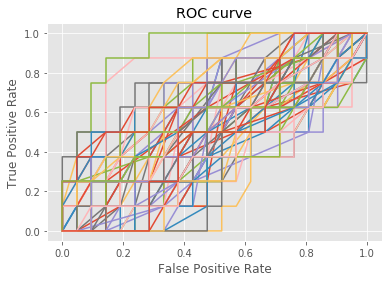

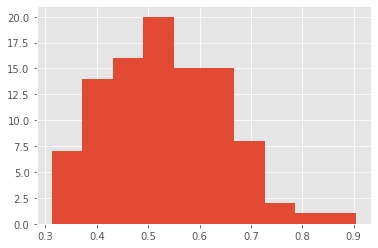

In [509]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# Random seed for reproducibility
SEED = 11

#c.run(list(preselected_ensgs.ENSG))
c.run(None)

def run_override_using_optimal(data, seed=SEED, parameters=None):
    # Code the SVM classification process here for now, so that you don't have to reinstantiate the classifier 
    # (block above) every time you make a change. Parameters are optional, no need to include them until fine-tuning
    # probably.
    
    # Extract the labels
    labels = np.array(c.subsetted_tpm.index.get_level_values(1))

    # Set aside test data
    train, test, train_labels, test_labels = train_test_split(data, 
                                                              labels, 
                                                              stratify = labels,
                                                              test_size=0.3,
                                                              random_state = SEED)

    print('\t{} examples in training set'.format(len(train)))
    print('\t{} examples in test set'.format(len(test)))
    
    print('\t{}: fraction of positives in training set'.format(
        sum(train.index.get_level_values(1))/len(train.index.get_level_values(1))))
    print('\t{}: fraction of positives in test set'.format(
        sum(test.index.get_level_values(1))/len(test.index.get_level_values(1))))

    # Make a model
    model = RandomForestClassifier(
        n_estimators=8,
        random_state=seed,
        max_features = 'sqrt',
        max_depth = 3,
        min_samples_split = 3
    )

    
    # Train model
    model.fit(train, train_labels)

    # Original guesses using default 0.5 threshold
    guesses = model.predict(test)
    
    # Probabilities per class
    probs = model.predict_proba(test)[:, 1]
    
    # Adjusted guess using a threshold optimized for reducing false negatives
    adjusted_guesses = [1 if p > 0.35 else 0 for p in probs]
    
    roc_value = roc_auc_score(test_labels, probs)
    print('roc_value:', roc_value)
    
    print(pd.DataFrame(confusion_matrix(test_labels, guesses),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    
    print(pd.DataFrame(confusion_matrix(test_labels, adjusted_guesses),
                       columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
        
    fpr, tpr, thresholds = roc_curve(test_labels, probs, pos_label=1)
    #print('Thresholds: ', thresholds)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')

    feature_importance = pd.DataFrame({
        'feature': list(train.columns),
        'importance': model.feature_importances_}).\
    sort_values('importance', ascending = False)
    return roc_value
    #print(feature_importance)
    
    #most_important_ensgs = [i[0] for i in  list(feature_importance[1:72].feature)]
    #print(most_important_ensgs)
    
roc_values = []
for seed in range(1, 100):
    roc_values.append(run_override_using_optimal(c.subsetted_tpm, seed=seed))

plt.figure()
plt.hist(roc_values)


In [511]:
sum(roc_values)/len(roc_values)

0.5350829725829724